miniconda environment: 
- tensorflow 2.10.0 (GPU setup)
- python 3.10.4

In [1]:
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard import notebook
import time
from datetime import datetime
import os

# Launch tensorboard in VS-Code
%load_ext tensorboard

# If using GPU, specify XLA_GPU_CUDA path (comment out otherwise)
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

tf.keras.backend.set_floatx('float32')
np.set_printoptions(precision=5, edgeitems=10, linewidth=1000, suppress=True)
tf.random.set_seed(0)

Tensorflow version: 2.10.0


# Carmona problem with bistable potential and network structures

We consider a stochastic differential game with $N$ players, and we denote by $\mathcal{I} := {1, 2, \dots, N}$ the set of players. Let $T$ be a finite time horizon. At each time $t \in [0, T]$, player $i \in \mathcal{I}$ has a state $X_{t}^{i} \in \mathbb{R}$ and takes an action $\alpha_{t}^{i} \in \mathbb{R}$. The dynamics of the controlled state process $X_{i}$ on $[0, T]$ are given by:

$$\mathrm{d} X_t^i=\left[-hU(X^{i}_t) + a\left(\bar{X}_t-X_t^i\right)+\alpha_t^i\right] \mathrm{d} t+\sigma\left(\rho \mathrm{d} W_t^0+\sqrt{1-\rho^2} \mathrm{~d} W_t^i\right)$$

where $\mathbf{X_0} = -1, -hU(y) = y^3 - y$ and $\boldsymbol{W}:=\left[W^0, W^1, \ldots, W^N\right]$ are ($N+1$) $m$-dimensional independent Brownian motions, with $W^{i}$ the individual noises and $W^{0}$ the common noise.

Given a set of strategies $(\mathbf{\alpha}_{t})_{t \in [0, T]}$, the cost associated to player $i$ is of the form
$$ J^{i}(\alpha): \alpha \mapsto \mathbb{E}\left[\int_0^T f^{i}\left(t, X_t, \alpha_{t}\right) dt+g^{i}(X_T)\right], $$

Here $f^i:[0, T] \times \mathbb{R}^N \times \mathbb{R}^N \rightarrow \mathbb{R}$ denotes the running cost, and $g^i: \mathbb{R}^N \rightarrow \mathbb{R}$ the terminal cost, where:
$$f^i(t, \boldsymbol{x}, \boldsymbol{\alpha})=\frac{1}{2}\left(\alpha^i\right)^2-q \alpha^i\left(\bar{x}-x^i\right)+\frac{\epsilon}{2}\left(\bar{x}-x^i\right)^2$$
$$g^i(\boldsymbol{x})=\frac{c}{2}\left(\bar{x}-x^i\right)^2$$

# Graph extension
We extend the Carmona inter-bank lending game by introducing network structures that dictate the interactions between bank $i$ and $j$. Let $\bf{A}$ be a symmetric adjacency matrix with values $a_{ij}$, with $i, j \in \{1,\dots,N\}$. We replace $\bar{X}_{t}:= \frac{1}{N} \sum_{j=1}^{N} X^{j}_{t}$ with the analogous mean of interacting banks, $\bar{X}^{i}_{t} := \frac{\sum_{j=1}^{N} a_{ij} X^{j}_{t}}{\sum_{j=1}^{N} a_{ij}}$. Otherwise, the problem remains the same.

# Solution method

We solve the above problem using direct parameterization methods.

We approximate the dynamics and the expected cost by discretized versions:
$$\check{X}_{t_{n+1}}=\check{X}_{t_n} + [-hU(\check{X}_{t_n}) + a\left(\check{X}_{t_n} - \check{X}^{i}_{t_n}\right) + \alpha^{i}_{t_n}] \Delta t + \sigma \Delta \check{W}_{t_n}, $$
$$\mathbb{E}\left[\sum_{n=0}^{N_T-1} f\left(t_n, \check{X}_{t_n}, \alpha_{t_n}\right) \Delta t+g\left(\check{X}_T\right)\right], $$
where

$$\begin{align*}
\Delta \check{W}_{t_n}&:=\check{W}_{t_{n+1}}-\check{W}_{t_n} \\
&= \rho \Delta \check{W}^{0}_{t_{n}} + \sqrt{1-\rho^2} \Delta\check{W}^{i}_{t_{n}}
\end{align*}$$

 are i.i.d random variables, and  $\Delta\check{W}^{0}, \Delta\check{W}^{i} \sim \mathcal{N}\left(0, \Delta t\right)$.

We approximate the control at each time step $\alpha_{t_{n}}$ by a feedforward neural network $\alpha_{t_{n}}(.; \theta_{n})$, taking inputs $\mathbb{S}:=[t_{n}, \check{X}^{i}_{t_n}, \dots, \check{X}^{N}_{t_n}]$, where $\theta_{n}$ denotes all neural network's parameters at time $t_{n}$.

In [2]:
# Parameters
h = 0.1
sigma = 8
a = 6
q = 1
eps = 1.5
rho = 0.2
c = 1
T = 1
N_T = 500 # Number of subintervals on [0, T]
dt = T/N_T # Time increment
N = 22 # Number of players
X0 = -np.ones((N))

# Neural Network

We use a feedforward neural network that takes as input an $(N+1)$-dimensional state vector $\mathbb{S}:=[t_{n}, \check{X}^{i}_{t_{n}}, \dots, \check{X}^{N}_{t_{n}}]$, and outputs an $N$-dimensional vector $\mathbb{\hat{\alpha}}:=[\hat{\alpha}^{i}_{t_{n}}, \dots, \hat{\alpha}^{N}_{t_{n}}]$ corresponding to the players' control.

In [3]:
# Neural network architecture parameters
num_input_nodes = N+1
num_output_nodes = N

# Define a feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes)
])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1536      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 22)                1430      
                                                                 
Total params: 7,126
Trainable params: 7,126
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Load weights
# model.load_weights('./weights/model_weights')

# Functions

In [17]:
def nearest_neighbour():
    A = np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)
    return tf.cast(A, dtype=tf.float32)

In [21]:
A = nearest_neighbour()

We generate Brownian increments $(\Delta\check{W}^{i}_{t_{n}})_{i=1,\dots,N}$, which are i.i.d random variables with Gaussian distribution: $\Delta\check{W} \sim \mathcal{N}\left(0, \Delta t\right)$.

We discretise the time interval $[0, T]$ into $N_{T}$ steps, so $\Delta t = \frac{T}{N_{T}}$.

We include the antithetic variates of the Brownian samples to reduce the variation of our simulated results.

In [18]:
def BMIncrements(B, N, antithetic=True):
    """Generate a Brownian Motion increment for each player

    Args:
        B: Number of increments
        N: Number of players

    Returns:
        Brownian increments, with its antithetic variates if antithetic==True
    """

    if antithetic == True:
        assert B%2 == 0, "Number of generated samples should be even if including antithetic variates"
        dat = tf.random.normal(shape=(B//2, N))*np.sqrt(dt)
        return tf.concat([dat, -dat], axis=0)
    else:
        return tf.random.normal(shape=(B, N))*np.sqrt(dt)

In [19]:
def compute_X_bar_i(X, A):
    """Compute the average of X conditional on interactions of bank i"""
    X_bar = tf.TensorArray(dtype=tf.float32, size=N)

    for j in tf.range(N):
        X_bar_i = tf.reduce_sum(A[j, :] * X, axis=1)
        X_bar = X_bar.write(j, X_bar_i)

    X_bar = tf.transpose(X_bar.stack())

    X_bar = X_bar / tf.reduce_sum(A, axis=1) 

    return X_bar

In [31]:
def euler_maruyama_graph(X0, N_T, dt, A, common_noise=True):
    """Compute sample paths using the Euler Maruyama scheme

    Args:
        X0: Initial condition
        N_T: Number of time steps
        dt: Time step size
        A: Adjacency matrix
        common_noise: Boolean for whether to include common noise
    """

    X_store = np.zeros((N_T+1, N))

    # Compute (N_T, N) Brownian increments
    dW = BMIncrements(N_T, N, antithetic=False)
    if common_noise:
        dW0 = BMIncrements(N_T, 1, antithetic=False)
        dW = rho*dW0 + (1-rho**2)**0.5*dW

    for nt in range(N_T+1):
        if nt == 0:
            X = X0 
        else:
            # Compute mean across players (columns)
            X_bar = np.zeros_like(X)
            for j in range(N):
                X_bar[j] = np.sum(A[j, :] * X)
            X_bar = X_bar / np.sum(A, axis=1) 

            # Evolve dynamics of X
            X = X + (-h*(X**3 - X) + a*(X_bar-X))*dt + sigma*dW[nt-1]
            
        X_store[nt] = X

    return X_store

In [32]:
def plot_euler_maruyama_graph(X0, N_T, dt, A, common_noise=True):
    """Plot sample paths from Euler Maruyama scheme"""

    X_store = euler_maruyama_graph(X0, N_T, dt, A, common_noise)
    X_bar = np.mean(X_store, axis=1, keepdims=True)

    fig, ax1 = plt.subplots(1, 1, figsize=(22, 6))
    fig.set_facecolor('white')

    t_axis = np.arange(start=0, stop=(N_T+1)*dt, step=dt)

    ax1.set_title("X")
    # ax1.plot(t_axis, X_store)
    ax1.plot(t_axis, X_bar, color='black', label='X_bar')
    ax1.set_xlabel("Time t")
    ax1.set_ylabel("$\hat{X}_{t}$")
    ax1.legend()

    plt.show()

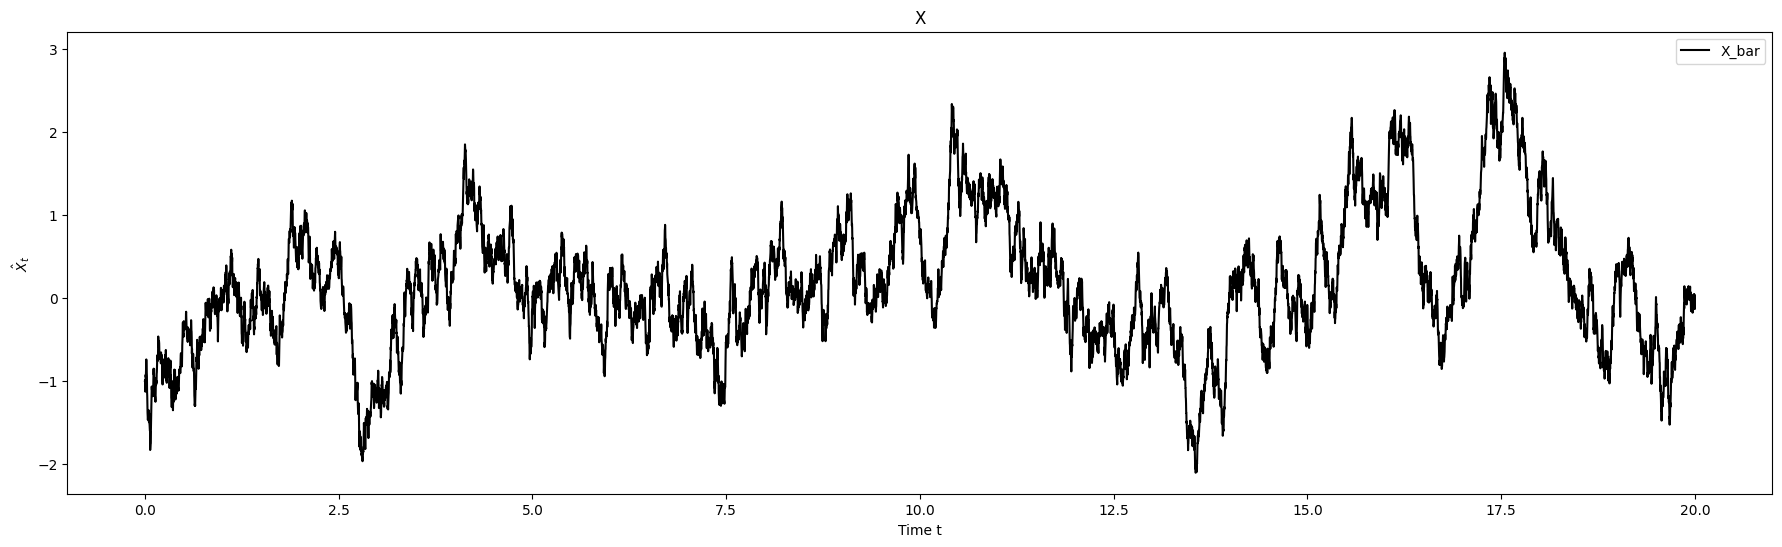

In [33]:
plot_euler_maruyama_graph(X0, 10000, dt, A, common_noise=False)

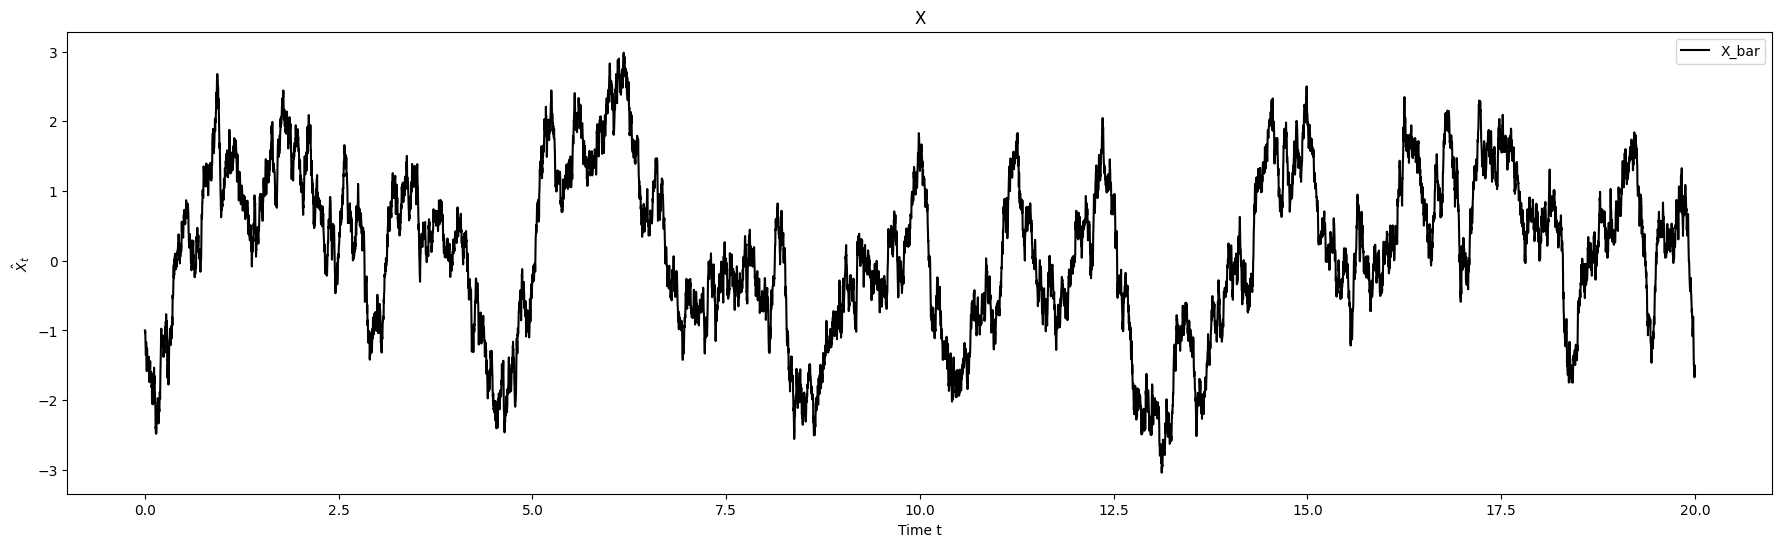

In [34]:
plot_euler_maruyama_graph(X0, 10000, dt, A, common_noise=True)

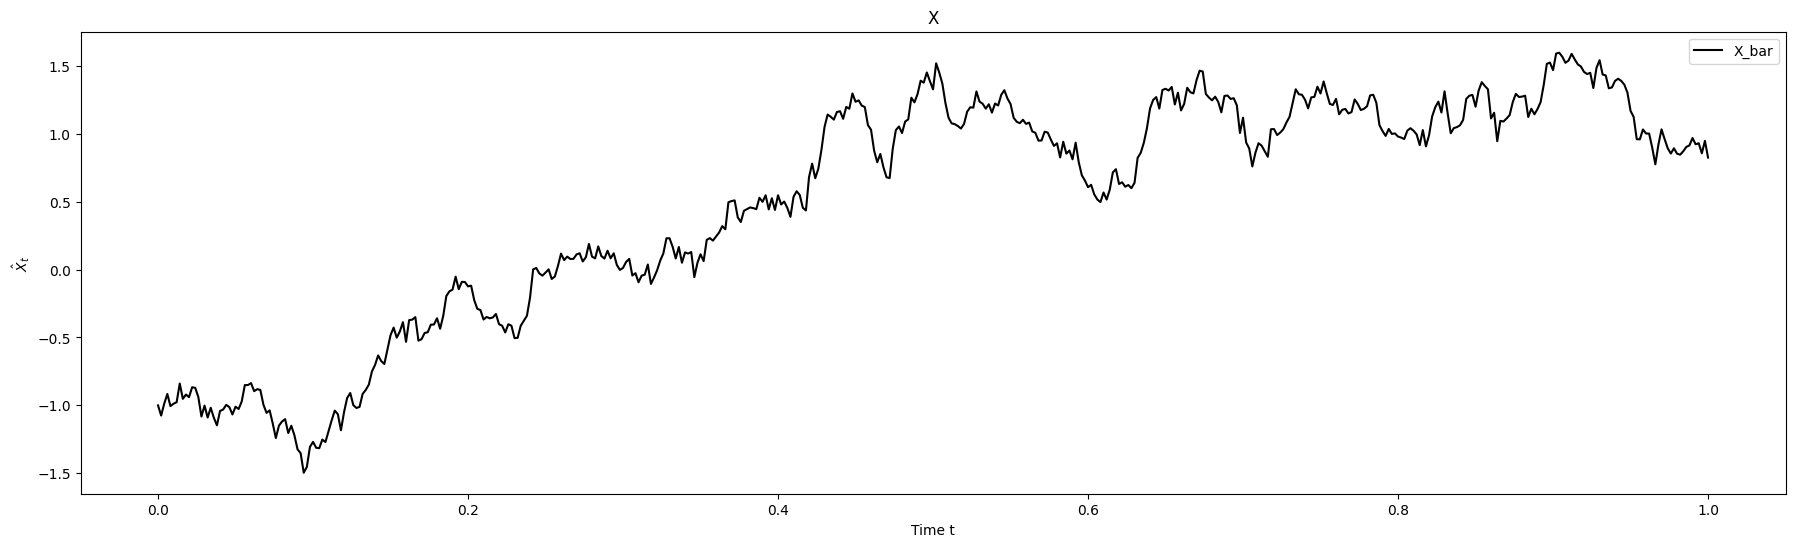

In [35]:
plot_euler_maruyama_graph(X0, 500, dt, A, common_noise=False)

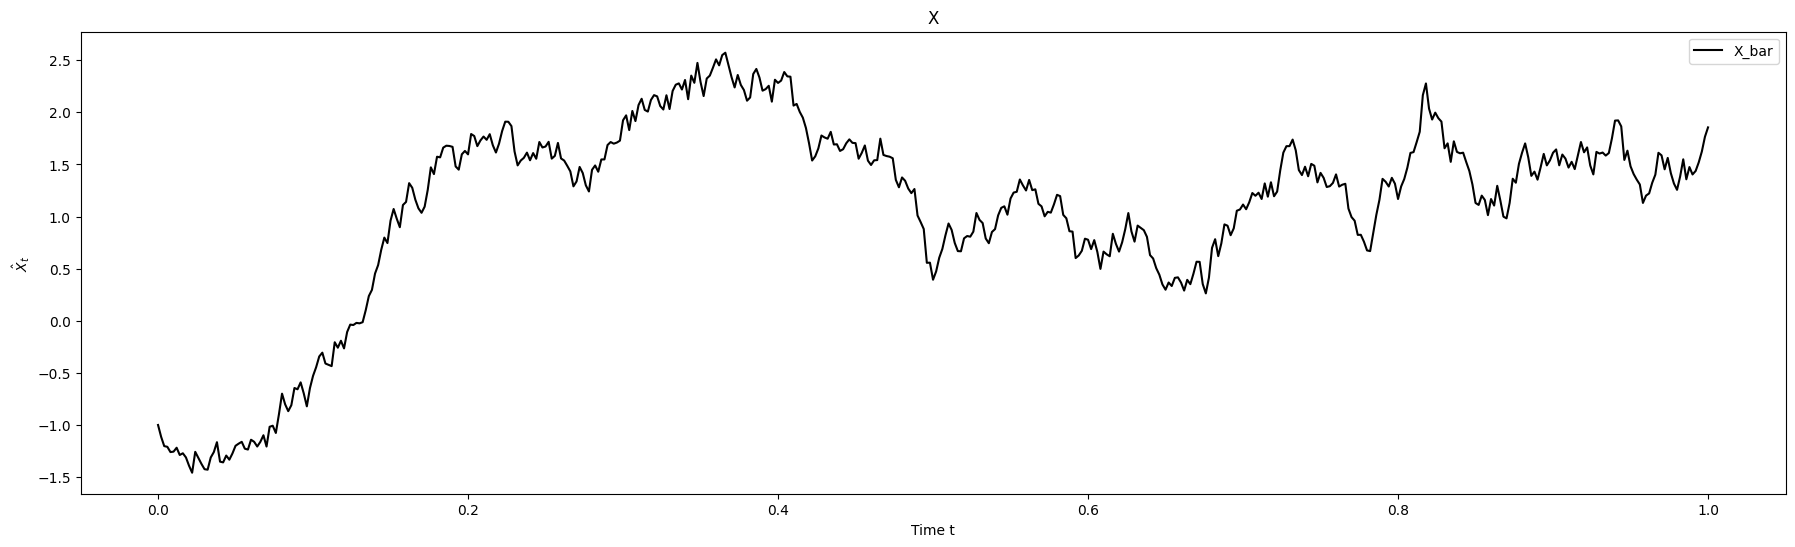

In [36]:
plot_euler_maruyama_graph(X0, 500, dt, A, common_noise=True)

In [37]:
def X_dynamics(X, X_bar, alpha, dW):
    """Simulate one step of the dynamics of X

    Args:
        X: State at time tn
        X_bar: Mean of N player's state at time tn
        alpha: Control
        dW: Brownian motion increment

    Returns:
        X_prime: State at time t_{n+1}
    """

    X_prime = X + (-h*(X**3 - X) + a*(X_bar-X) + alpha)*dt + sigma*dW
    return X_prime

def f(X, X_bar, alpha):
    """The running cost at time t

    Args:
        X: State at time t
        X_bar: Mean at time t
        alpha: Control at time t

    Returns:
        running_cost: The running cost at time t
    """
    return 0.5*alpha**2 - q*alpha*(X_bar-X) + 0.5*eps*(X-X_bar)**2

def g(X, X_bar):
    """Final time penalty

    Args:
        X: State of player i at time T
        X_bar: Mean at time T

    Returns:
        terminal_cost: The terminal cost at time T
    """
    return c/2*(X-X_bar)**2

In [39]:
def one_step_simulation(S, antithetic=True):
    """Given the state S at time tn, predict the control at time tn, and then the state and cost at time t_{n+1}
    
    Args:
        S: (N+1)-dimensional state vector at time tn

    Returns:
        S_prime: State at time t_{n+1}
        alpha: Control at time t_{n+1}
        cost: Running cost at time t_{n+1} 
    """
    # Unpack state vector and compute X_bar
    t = tf.expand_dims(S[:, 0], axis=1)
    X = S[:, 1:]
    X_bar = compute_X_bar_i(X, A)
    
    # Predict control at time tn
    alpha = model(S)

    # Compute running cost at time tn
    terminal_cost = g(X, X_bar)
    running_cost = f(X, X_bar, alpha)
    cost = tf.where(t == T, terminal_cost, running_cost)

    # Compute N-dimensional Brownian and common noise increments
    dWi = BMIncrements(X.shape[0], N, antithetic=antithetic)
    dW0 = BMIncrements(X.shape[0], 1, antithetic=antithetic)
    dW = rho*dW0 + (1-rho**2)**0.5*dWi

    # Compute next period state:
    t_prime = t + dt
    X_prime = X_dynamics(X, X_bar, alpha, dW)

    S_prime = tf.concat([t_prime, X_prime], axis=1)

    return S_prime, alpha, cost

In [40]:
def simulate(S):
    """Simulate forward from t0, X0 and return total loss

    Args:
        S: Training data

    Returns:
        total_cost: Total cost for each player
        optimal_cost: 0
    """
    
    # Initialise total cost
    total_cost = tf.zeros((tf.shape(S)[0], N))

    # Loop from 0 to N_T
    for nt in range(N_T):
        S_prime, _, cost = one_step_simulation(S)

        # Evolve state
        S = S_prime

        # Compute running cost
        total_cost = total_cost + cost
        
    optimal_cost = tf.zeros_like(total_cost)

    return total_cost, optimal_cost

# Training

In [41]:
# Hyper-parameters
batch_size = 32
lr = 1e-3

# Use Mean-Squared Error as loss metric
mse = tf.keras.losses.MeanSquaredError()
# Adam optimizer with amsgrad for added stability, and jit_compile for improved training speed
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, jit_compile=True)

model.compile(
    optimizer,
    loss='mse'
)

## Training loop

In [42]:
@tf.function(jit_compile=True)
def train_step(S):
    """Train step

    Args:
        S: Training data

    Returns:
        Mean-squared error
    """

    # Automatic differentiation
    with tf.GradientTape() as tape:

        # Forward pass of the model to get total cost
        total_cost, optimal_cost = simulate(S)

        # Compute batch loss value
        loss_value = mse(total_cost, optimal_cost)               

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value

In [43]:
# @tf.function
def training_algorithm(S, num_epochs):

    # Initialise metrics to get mean loss per epoch
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()

        # Batch training data
        S_train = S.batch(batch_size)

        # Mini-batch gradient descent
        for S_batch in S_train:
            
            # Training step
            loss_value = train_step(S_batch)      
                        
            # Update the metrics per epoch
            epoch_loss_metric.update_state(loss_value)              
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}: log10(loss): {tf.experimental.numpy.log10(epoch_mean_loss):.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

In [91]:
%tensorboard --logdir logs/gradient_tape --host localhost

Reusing TensorBoard on port 6006 (pid 34572), started 0:00:03 ago. (Use '!kill 34572' to kill it.)

## Begin training

In [44]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
training_data = tf.concat([tf.zeros((batch_size, 1)), -tf.ones((batch_size, N))], axis=1)
with train_summary_writer.as_default():
    training_algorithm(tf.data.Dataset.from_tensor_slices(training_data), 1001)

Epoch 0: log10(loss): 6.27883
Epoch 100: log10(loss): 5.56592
Epoch 200: log10(loss): 5.24859
Epoch 300: log10(loss): 5.13265
Epoch 400: log10(loss): 5.11911
Epoch 500: log10(loss): 5.03033
Epoch 600: log10(loss): 5.02895
Epoch 700: log10(loss): 5.00034
Epoch 800: log10(loss): 4.99967
Epoch 900: log10(loss): 4.94508
Epoch 1000: log10(loss): 5.00567
Training took 01:11:25


In [56]:
# save weights
# model.save_weights('./weights/bistablegraph_N22_NT500_nearestneighbour')

# Plots

In [45]:
def forward_pass():
    """Computes the dynamics X, controls and running cost from the deep learning solution"""
    
    S = tf.concat([tf.zeros((1, 1)), -tf.ones((1, N))], axis=1)
    X_store = np.zeros((N_T+1, N))
    alpha_store = np.zeros((N_T+1, N))
    cost_store = np.zeros((N_T+1, N))
 
    for nt in range(N_T+1):
        X_store[nt] = S[0, 1:]
        S_prime, alpha, cost = one_step_simulation(S, antithetic=False)
        alpha_store[nt] = tf.squeeze(alpha)
        cost_store[nt] = tf.squeeze(cost)

        # Evolve state
        S = S_prime

    return X_store, alpha_store, cost_store

In [54]:
X_store, _, _ = forward_pass()

In [47]:
def plot_solution(X_store, k=N):
    """Plot deep learning solution
    
    Args:
        k: Number of players to plot, integer. Defaults to N.
    """

    assert type(k) == int, "k must be an integer less than or equal to N"
    assert k <= N, "k must not exceed N"

    idx = random.sample(range(N), k=k)

    X_bar = np.mean(X_store, axis=1, keepdims=True)

    fig, (ax1) = plt.subplots(1, 1, figsize=(22, 6))
    fig.set_facecolor('white')

    t_axis = np.arange(start=0, stop=(N_T+1)*dt, step=dt)

    ax1.set_title("X")
    ax1.plot(t_axis, X_store[:, idx])
    ax1.plot(t_axis, X_bar, color='black', linewidth=2, label='X_bar')
    ax1.set_xlabel("Time t")
    ax1.set_ylabel("$\hat{X}_{t}$")
    ax1.legend()

    plt.show()

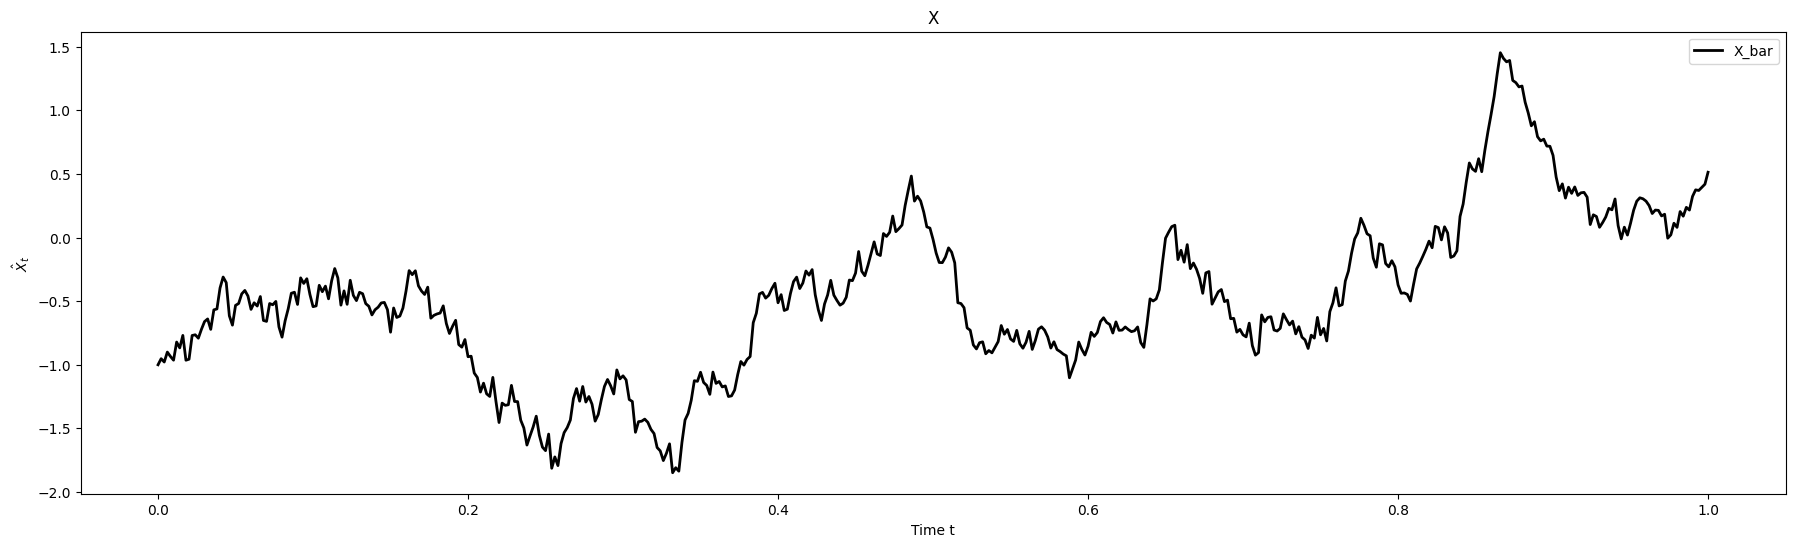

In [55]:
plot_solution(X_store, 0)